<a href="https://colab.research.google.com/github/yoyoyo-yo/DeepLearningMugenKnock/blob/master/scripts/GradCAM_STL10_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

VGG16, CIFAR100

In [1]:
!pip install numpy matpltlib opencv-python torch torchvision torchsummary pandas easydict

ERROR: Could not find a version that satisfies the requirement matpltlib (from versions: none)
ERROR: No matching distribution found for matpltlib


## Import and Config

In [60]:
import os
from pprint import pprint
import argparse

import numpy as np
from collections import OrderedDict
from easydict import EasyDict
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import seaborn as sns

import torch
import torch.nn.functional as F
import torchvision
from torchsummary import summary
from torchvision import transforms

#---
# config
#---
cfg = EasyDict()

# class
cfg.CLASS_LABEL = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck'] # list, dict('label' : '[B, G, R]')
cfg.CLASS_NUM = len(cfg.CLASS_LABEL)

# model
cfg.INPUT_HEIGHT = 96
cfg.INPUT_WIDTH = 96
cfg.INPUT_CHANNEL = 3
cfg.INPUT_MODE = 'RGB' #RGB, GRAY, CLASS_LABEL, EDGE

cfg.CHANNEL_AXIS = 1 # 1 ... [mb, c, h, w], 3 ... [mb, h, w, c]

cfg.GPU = True
cfg.DEVICE_TYPE = 'cuda' if cfg.GPU and torch.cuda.is_available() else 'cpu'
cfg.DEVICE = torch.device(cfg.DEVICE_TYPE)


# train
cfg.TRAIN = EasyDict()
cfg.TRAIN.DISPAY_ITERATION_INTERVAL = 50

cfg.PREFIX = 'VGG16'
cfg.TRAIN.MODEL_SAVE_PATH = 'models/' + cfg.PREFIX + '_{}.pt'
cfg.TRAIN.MODEL_SAVE_INTERVAL = 10_000
cfg.TRAIN.ITERATION = 5_000
#cfg.TRAIN.EPOCH = 2
cfg.TRAIN.MINIBATCH = 64
cfg.TRAIN.OPTIMIZER = torch.optim.SGD
cfg.TRAIN.LEARNING_PARAMS = {'lr' : 0.01, 'momentum' : 0.9} #{'lr' : 0.02, 'betas' : (0.5, 0.9)}

cfg.TRAIN.DATA_PATH = './data/' # 'drive/My Drive/Colab Notebooks/Dataset/train/images/'
cfg.TRAIN.DATA_HORIZONTAL_FLIP = False
cfg.TRAIN.DATA_VERTICAL_FLIP = False
cfg.TRAIN.DATA_ROTATION = False

cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE = True
cfg.TRAIN.LEARNING_PROCESS_RESULT_INTERVAL = 500
cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'
cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH = 'result/' + cfg.PREFIX + '_loss.csv'

# test
cfg.TEST = EasyDict()
cfg.TEST.MODEL_PATH = cfg.TRAIN.MODEL_SAVE_PATH.format('final')
cfg.TEST.DATA_PATH = './data/' # 'drive/My Drive/Colab Notebooks/Dataset/test/images/
cfg.TEST.MINIBATCH = 100
cfg.TEST.ITERATION = 2
cfg.TEST.MAX_NUM = 100
cfg.TEST.RESULT_SAVE = False
cfg.TEST.RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'

# random seed
torch.manual_seed(0)


# make model save directory
def make_dir(path):
    if '/' in path:
        model_save_dir = '/'.join(path.split('/')[:-1])
        os.makedirs(model_save_dir, exist_ok=True)

make_dir(cfg.TRAIN.MODEL_SAVE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH)
    
pprint(cfg)

{'CHANNEL_AXIS': 1,
 'CLASS_LABEL': ['airplane',
                 'bird',
                 'car',
                 'cat',
                 'deer',
                 'dog',
                 'horse',
                 'monkey',
                 'ship',
                 'truck'],
 'CLASS_NUM': 10,
 'DEVICE': device(type='cuda'),
 'DEVICE_TYPE': 'cuda',
 'GPU': True,
 'INPUT_CHANNEL': 3,
 'INPUT_HEIGHT': 96,
 'INPUT_MODE': 'RGB',
 'INPUT_WIDTH': 96,
 'PREFIX': 'VGG16',
 'TEST': {'DATA_PATH': './data/',
          'ITERATION': 2,
          'MAX_NUM': 100,
          'MINIBATCH': 100,
          'MODEL_PATH': 'models/VGG16_final.pt',
          'RESULT_IMAGE_PATH': 'result/VGG16_result_{}.jpg',
          'RESULT_SAVE': False},
 'TRAIN': {'DATA_HORIZONTAL_FLIP': False,
           'DATA_PATH': './data/',
           'DATA_ROTATION': False,
           'DATA_VERTICAL_FLIP': False,
           'DISPAY_ITERATION_INTERVAL': 50,
           'ITERATION': 5000,
           'LEARNING_PARAMS': {'lr': 0.01, 'momen

## Define Model

In [0]:

class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.view(-1)

class VGG_block(torch.nn.Module):
    def __init__(self, dim1, dim2, repeat=3, name=''):
        super(VGG_block, self).__init__()
        self.module = torch.nn.Sequential()
        for i in range(repeat):
            _dim1 = dim1 if i == 0 else dim2
            self.module.add_module('{}_{}_conv'.format(name, i + 1), torch.nn.Conv2d(_dim1, dim2, kernel_size=3, padding=1, stride=1))
            self.module.add_module('{}_{}_act'.format(name, i + 1), torch.nn.ReLU())
            self.module.add_module('{}_{}_bn'.format(name, i + 1), torch.nn.BatchNorm2d(dim2))

    def forward(self, x):
        return self.module(x)


class VGG16(torch.nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.module = torch.nn.Sequential(OrderedDict({
            'block1' : VGG_block(cfg.INPUT_CHANNEL, 64, repeat=2, name='block1'),
            'pool1' : torch.nn.MaxPool2d(2, stride=2),
            'block2' : VGG_block(64, 128, repeat=2, name='block2'),
            'pool2' : torch.nn.MaxPool2d(2, stride=2),
            'block3' : VGG_block(128, 256, repeat=3, name='block3'),
            'pool3' : torch.nn.MaxPool2d(2, stride=2),
            'block4' : VGG_block(256, 512, repeat=3, name='block4'),
            'pool4' : torch.nn.MaxPool2d(2, stride=2),
            'block5' : VGG_block(512, 512, repeat=3, name='block5'),
            'pool5' : torch.nn.MaxPool2d(2, stride=2),
        }))

        self.top = torch.nn.Sequential(OrderedDict({
            'linear1' : torch.nn.Linear(512 * (cfg.INPUT_HEIGHT // 32) * (cfg.INPUT_WIDTH // 32), 256),
            'linear1_act' : torch.nn.ReLU(),
            'linear1_drop' : torch.nn.Dropout(p=0.2),
            'linear2' : torch.nn.Linear(256, 256),
            'linear2_act' : torch.nn.ReLU(),
            'linear2_drop' : torch.nn.Dropout(p=0.2),
        }))

        self.out = torch.nn.Sequential(
            torch.nn.Linear(256, cfg.CLASS_NUM),
            #torch.nn.Softmax(dim=1),
        )

    def forward(self, x):
        x = self.module(x)
        x = x.reshape(x.size()[0], -1)
        x = self.top(x)
        return self.out(x)

## Utility

In [0]:
class BatchGenerator():
    def __init__(self, data_size, batch_size, shuffle=True):
        self.data_size = data_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.mbi = 0 # index for iteration
        self.inds = np.arange(data_size)
        if shuffle:
            np.random.shuffle(self.inds)

    def __call__(self):
        if self.mbi + self.batch_size >= self.data_size:
            inds = self.inds[self.mbi:]
            if self.shuffle:
                np.random.shuffle(self.inds)
            inds = np.hstack((inds, self.inds[ : (self.batch_size - (self.data_size - self.mbi))]))
            self.mbi = self.batch_size - (self.data_size - self.mbi)
        else:
            inds = self.inds[self.mbi : self.mbi + self.batch_size]
            self.mbi += self.batch_size
        return inds


## Train

In [10]:
def train():
    # model
    model = VGG16().to(cfg.DEVICE)
    model.train()
    
    summary(model, (cfg.INPUT_CHANNEL, cfg.INPUT_HEIGHT, cfg.INPUT_WIDTH))
    opt = cfg.TRAIN.OPTIMIZER(model.parameters(), **cfg.TRAIN.LEARNING_PARAMS)

    #path_dict = data_load(cfg)
    #paths = path_dict['paths']
    #paths_gt = path_dict['paths_gt']
    transform = transforms.Compose([
        transforms.Resize((cfg.INPUT_HEIGHT, cfg.INPUT_WIDTH)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

    ds = torchvision.datasets.STL10(root=cfg.TRAIN.DATA_PATH , split='train', download=True, transform=transform)
    Xs_data = torch.tensor(ds.data, dtype=torch.float).to(cfg.DEVICE)
    Xs_data = Xs_data / 127.5 - 1
    ts_data = torch.tensor(ds.labels, dtype=torch.long).to(cfg.DEVICE)
    data_num = len(Xs_data)
    print(Xs_data.shape)
    #train_ts = np.identity(cfg.CLASS_NUM)[trainset.targets] # one hot

    # training
    batch_gen = BatchGenerator(data_num, cfg.TRAIN.MINIBATCH)
    
    loss_func = torch.nn.CrossEntropyLoss()

    list_iter = []
    list_loss= []
    list_accuracy = []

    print('training start')
    progres_bar = ''
    
    for i in range(cfg.TRAIN.ITERATION):
        # sample X and t
        mb_inds = batch_gen()
        #Xs = torch.tensor(preprocess(Xs_data[mb_inds], cfg, cfg.INPUT_MODE), dtype=torch.float).to(cfg.DEVICE)
        Xs = Xs_data[mb_inds]
        ts = ts_data[mb_inds]

        # forward and update
        opt.zero_grad()

        ys = model(Xs)

        loss = loss_func(ys, ts)
        loss.backward()
        opt.step()
    
        preds = ys.argmax(dim=1)
        accuracy = (preds == ts).sum() / float(cfg.TRAIN.MINIBATCH)

        _loss = loss.item()
        _accuracy = accuracy.item()

        progres_bar += '|'

        if (i + 1) % 10 == 0:
            progres_bar += str(i + 1)

            # save process result
            if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
                list_iter.append(i + 1)
                list_loss.append(_loss)
                list_accuracy.append(_accuracy)

        print('\r' + 'Loss:{:.4f}, Accu:{:.4f} '.format(_loss, _accuracy) + progres_bar, end='')

                
        # display training state
        if (i + 1) % cfg.TRAIN.DISPAY_ITERATION_INTERVAL == 0:
            print('\r' + ' ' * len(progres_bar), end='')
            print('\rIter:{}, Loss:{:.4f}, Accu:{:.4f}'.format(i + 1, _loss, _accuracy))
            progres_bar = ''

        # save parameters
        if (cfg.TRAIN.MODEL_SAVE_INTERVAL != False) and ((i + 1) % cfg.TRAIN.MODEL_SAVE_INTERVAL == 0):
            save_path = cfg.TRAIN.MODEL_SAVE_PATH.format('iter{}'.format(i + 1))
            torch.save(model.state_dict(), save_path)
            print('save >> {}'.format(save_path))


    save_path = cfg.TRAIN.MODEL_SAVE_PATH.format('final')
    torch.save(model.state_dict(), save_path)
    print('final paramters were saved to >> {}'.format(save_path))

    if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
        f = open(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, 'w')
        df = pd.DataFrame({'iteration' : list_iter, 'loss' : list_loss, 'accuracy' : list_accuracy})
        df.to_csv(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, index=False)
        print('loss was saved to >> {}'.format(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH))

train()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 96, 96]           1,792
              ReLU-2           [-1, 64, 96, 96]               0
       BatchNorm2d-3           [-1, 64, 96, 96]             128
            Conv2d-4           [-1, 64, 96, 96]          36,928
              ReLU-5           [-1, 64, 96, 96]               0
       BatchNorm2d-6           [-1, 64, 96, 96]             128
         VGG_block-7           [-1, 64, 96, 96]               0
         MaxPool2d-8           [-1, 64, 48, 48]               0
            Conv2d-9          [-1, 128, 48, 48]          73,856
             ReLU-10          [-1, 128, 48, 48]               0
      BatchNorm2d-11          [-1, 128, 48, 48]             256
           Conv2d-12          [-1, 128, 48, 48]         147,584
             ReLU-13          [-1, 128, 48, 48]               0
      BatchNorm2d-14          [-1, 128,

## plot Loss, Accuracy

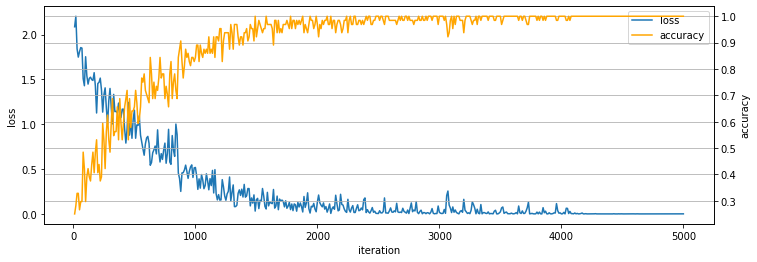

In [11]:
def plot_process():
    df = pd.read_csv(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH)
    
    fig, ax = plt.subplots(figsize=(12, 4))
    ax2 = ax.twinx()
    lns1 = ax.plot(df['iteration'], df['loss'], label='loss')
    lns2 = ax2.plot(df['iteration'], df['accuracy'], color='orange', label='accuracy')

    lns = lns1 + lns2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc=0)
    ax.set_ylabel('loss')
    ax.set_xlabel('iteration')
    ax2.set_ylabel('accuracy')
    plt.grid()
    plt.show()

plot_process()

## Test

--------------------
test function
--------------------
Files already downloaded and verified
8000 / 8000
accuracy = 0.708875
ts / pred table
array([[670.,  23.,  21.,   4.,   2.,   5.,   2.,   0.,  41.,  32.],
       [ 44., 538.,   3.,  75.,  23.,  37.,  12.,  54.,   8.,   6.],
       [ 13.,   7., 677.,  13.,   1.,   4.,   5.,   6.,  14.,  60.],
       [  4.,  58.,   2., 471.,  69.,  92.,  15.,  74.,   9.,   6.],
       [  9.,  39.,   2.,  75., 537.,  35.,  53.,  44.,   4.,   2.],
       [  6.,  54.,   3.,  94.,  54., 378.,  90., 112.,   3.,   6.],
       [  6.,  29.,   8.,  33.,  32.,  63., 585.,  31.,   0.,  13.],
       [  3.,  67.,   0.,  84.,  30.,  79.,  24., 508.,   1.,   4.],
       [ 33.,   9.,  23.,  11.,   5.,   1.,   1.,   0., 691.,  26.],
       [ 23.,   8.,  62.,  20.,   3.,   8.,   4.,   2.,  54., 616.]])


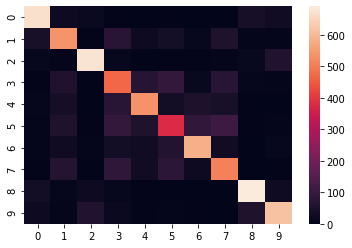

In [13]:
# test
def test():
    print('-' * 20)
    print('test function')
    print('-' * 20)
    model = VGG16().to(cfg.DEVICE)
    model.load_state_dict(torch.load(cfg.TEST.MODEL_PATH, map_location=torch.device(cfg.DEVICE)))
    model.eval()

    np.random.seed(0)

    ds= torchvision.datasets.STL10(root=cfg.TEST.DATA_PATH , split='test', download=True, transform=None)
    Xs_data = torch.tensor(ds.data, dtype=torch.float).to(cfg.DEVICE)
    Xs_data = Xs_data / 127.5 - 1
    ts_data = np.array(ds.labels)
    data_num = len(Xs_data)
    
    table = np.zeros([cfg.CLASS_NUM, cfg.CLASS_NUM])

    inds = np.arange(data_num)

    with torch.no_grad():
        for i in range(0, data_num, cfg.TEST.MINIBATCH):
            # get batch index
            mb_inds = inds[i : min(i + cfg.TEST.MINIBATCH, data_num)]
            Xs = Xs_data[mb_inds]
            ts = ts_data[mb_inds]

            # forward
            ys = F.softmax(model(Xs), dim=1).detach().cpu().numpy()
            ys = ys.argmax(axis=1)
            
            for t, y in zip(ts, ys):
                table[t, y] += 1

            print('\r{} / {}'.format(mb_inds[-1] + 1, data_num), end='')

    accuracy = table[np.arange(cfg.CLASS_NUM), np.arange(cfg.CLASS_NUM)].sum() / table.sum()
    print('\naccuracy =', accuracy)
    print('ts / pred table')
    pprint(table)
    sns.heatmap(table)

test()

# Grad CAM

In [0]:
import matplotlib.cm as cm

In [28]:
ds= torchvision.datasets.STL10(root=cfg.TEST.DATA_PATH , split='test', download=True, transform=None)
Xs_data = torch.tensor(ds.data, dtype=torch.float).to(cfg.DEVICE)
Xs_data = Xs_data / 127.5 - 1
ts_data = np.array(ds.labels)
data_num = len(Xs_data)

Files already downloaded and verified


In [0]:
fmap_pool = OrderedDict()
grad_pool = OrderedDict()

def forward_hook(key):
    def forward_hook_(module, input, output):
        # Save featuremaps
        fmap_pool[key] = output.detach()

    return forward_hook_

def backward_hook(key):
    def backward_hook_(module, grad_in, grad_out):
        # Save the gradients correspond to the featuremaps
        grad_pool[key] = grad_out[0].detach()

    return backward_hook_

# If any candidates are not specified, the hook is registered to all the layers.
for name, module in model.named_modules():
        module.register_forward_hook(forward_hook(name))
        module.register_backward_hook(backward_hook(name))

In [19]:
model = VGG16().to(cfg.DEVICE)
model.load_state_dict(torch.load(cfg.TEST.MODEL_PATH, map_location=torch.device(cfg.DEVICE)))
model.eval()

# display layer name
for name, module in model.named_modules():
    print(name)


module
module.block1
module.block1.module
module.block1.module.block1_1_conv
module.block1.module.block1_1_act
module.block1.module.block1_1_bn
module.block1.module.block1_2_conv
module.block1.module.block1_2_act
module.block1.module.block1_2_bn
module.pool1
module.block2
module.block2.module
module.block2.module.block2_1_conv
module.block2.module.block2_1_act
module.block2.module.block2_1_bn
module.block2.module.block2_2_conv
module.block2.module.block2_2_act
module.block2.module.block2_2_bn
module.pool2
module.block3
module.block3.module
module.block3.module.block3_1_conv
module.block3.module.block3_1_act
module.block3.module.block3_1_bn
module.block3.module.block3_2_conv
module.block3.module.block3_2_act
module.block3.module.block3_2_bn
module.block3.module.block3_3_conv
module.block3.module.block3_3_act
module.block3.module.block3_3_bn
module.pool3
module.block4
module.block4.module
module.block4.module.block4_1_conv
module.block4.module.block4_1_act
module.block4.module.block4_1_

In [0]:
target_layer_name = 'module.block5.module.block5_3_bn'

In [82]:
# get layer
for name, module in model.named_modules():
    if target_layer_name == name:
        print('target:', name)
        target_layer = module

target: module.block5.module.block5_3_bn


In [0]:
def grad_cam(x):
    # forward network
    logit = model(x)
    preds = F.softmax(logit, dim=1).detach().cpu().numpy()

    raw_image = x[0].cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5

    plt.figure(figsize=(20, 4))
    plt.subplot(1, cfg.CLASS_NUM + 1, 1)
    plt.imshow(raw_image)
    plt.title('input')

    cmaps = np.zeros([cfg.CLASS_NUM, cfg.INPUT_HEIGHT, cfg.INPUT_WIDTH, 3])

    for i, class_label in enumerate(cfg.CLASS_LABEL):
        # set one-hot class activity
        class_index = torch.zeros(preds.shape).to(cfg.DEVICE)

        _index = cfg.CLASS_LABEL.index(class_label)
        class_index[:, _index] = 1

        logit.backward(gradient=class_index, retain_graph=True)
        
        #target_layer_output = target_layer.forward(x)
        fmaps = fmap_pool[target_layer_name]
        grads = grad_pool[target_layer_name]
        weights = F.adaptive_avg_pool2d(grads, 1)

        gcam = torch.mul(fmaps, weights).sum(dim=1, keepdim=True)
        gcam = F.relu(gcam)

        gcam = F.interpolate(gcam, [cfg.INPUT_HEIGHT, cfg.INPUT_WIDTH], mode="bilinear", align_corners=False)

        B, C, H, W = gcam.shape
        gcam = gcam.view(B, -1)
        gcam -= gcam.min(dim=1, keepdim=True)[0]
        gcam /= gcam.max(dim=1, keepdim=True)[0]
        gcam = gcam.view(B, C, H, W)

        gcam = gcam.cpu().numpy()[0, 0]
        cmap = cm.jet(gcam)[..., :3]
        cmaps[i] = cmap

    # normalize inter class
    cmaps -= cmaps.min()
    cmaps /= cmaps.max()

    for i, class_label in enumerate(cfg.CLASS_LABEL): 
        gcam = (cmaps[i].astype(np.float) + raw_image.astype(np.float)) / 2
    
        plt.subplot(1, cfg.CLASS_NUM + 1, i + 2)
        plt.imshow(gcam)
        plt.title('{} :{:.4f}'.format(class_label, preds[0, i]))

    plt.show()

    #print('preds >>', preds)

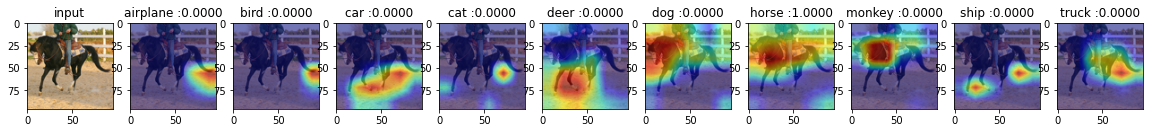

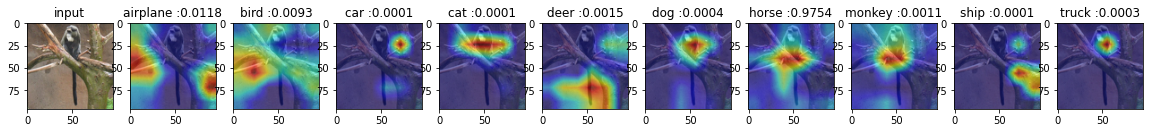

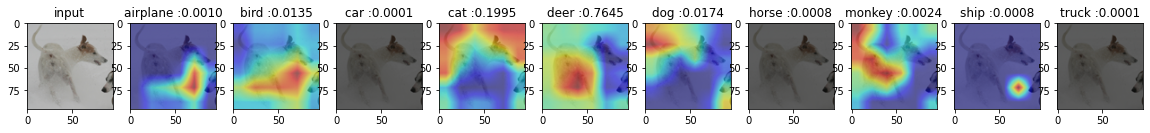

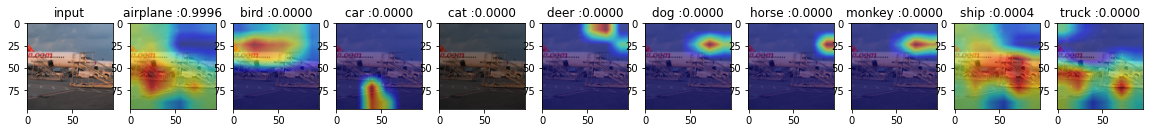

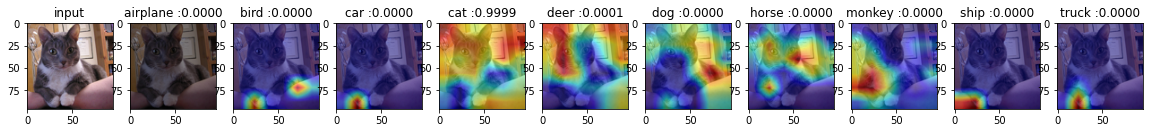

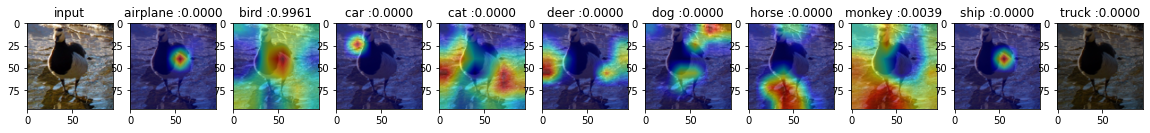

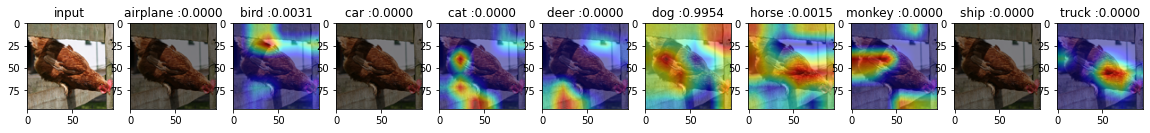

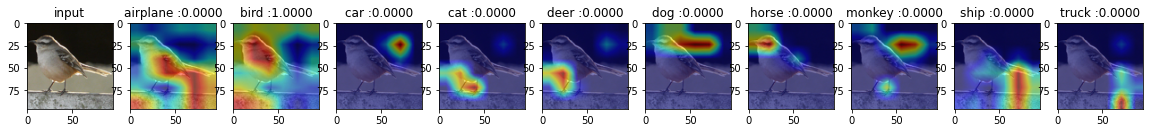

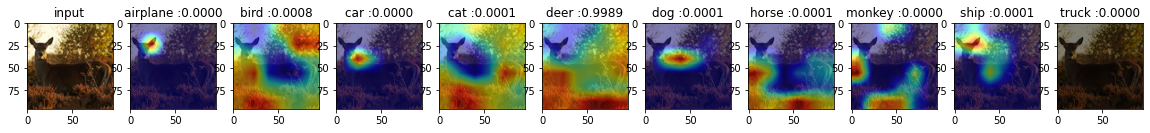

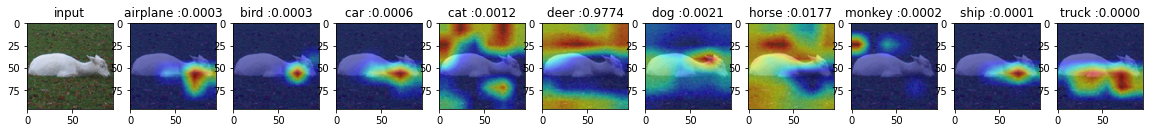

In [84]:
for i in range(10):
    grad_cam(Xs_data[[i]])